CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_9")

In [16]:
from utils import *
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
#     transforms.Resize((28, 28)),
#     transforms.RandomRotation((-15., 15.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])

train_transforms = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
     ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
     ])



CODE BLOCK: 4

In [7]:
# train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.CIFAR10('../data', train=True, download=True)
# test_data = datasets.CIFAR10('../data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

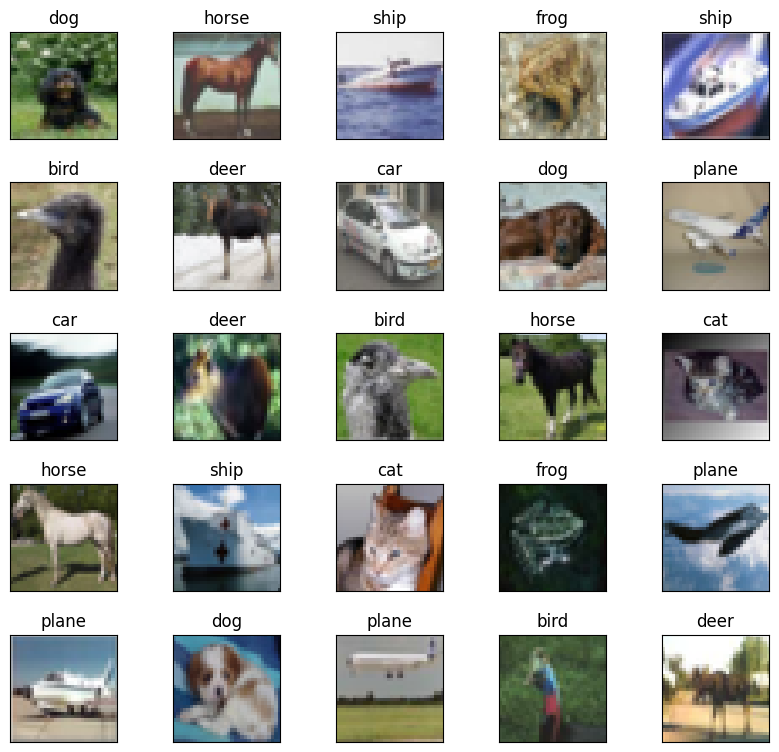

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s9_base_model().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 31, 31]          16,416
              ReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 32, 16, 16]           9,248
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 16, 16, 16]             528
           Conv2d-14           [-1, 32,

CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.5187 Batch_id=97 Accuracy=34.66: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s]


Test set: Average loss: 1.5023, Accuracy: 22436/50000 (44.87%)

Epoch 2


Train: Loss=1.1060 Batch_id=97 Accuracy=51.67: 100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


Test set: Average loss: 1.4147, Accuracy: 24143/50000 (48.29%)

Epoch 3


Train: Loss=1.1151 Batch_id=97 Accuracy=60.30: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


Test set: Average loss: 1.0506, Accuracy: 31261/50000 (62.52%)

Epoch 4


Train: Loss=0.9002 Batch_id=97 Accuracy=65.75: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


Test set: Average loss: 0.9370, Accuracy: 33210/50000 (66.42%)

Epoch 5


Train: Loss=0.8692 Batch_id=97 Accuracy=69.88: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Test set: Average loss: 0.9162, Accuracy: 33548/50000 (67.10%)

Epoch 6


Train: Loss=0.8075 Batch_id=97 Accuracy=72.90: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


Test set: Average loss: 0.8786, Accuracy: 34543/50000 (69.09%)

Epoch 7


Train: Loss=0.6334 Batch_id=97 Accuracy=74.91: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.8174, Accuracy: 35598/50000 (71.20%)

Epoch 8


Train: Loss=0.7115 Batch_id=97 Accuracy=76.92: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]


Test set: Average loss: 0.6815, Accuracy: 37911/50000 (75.82%)

Epoch 9


Train: Loss=0.6963 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Test set: Average loss: 0.6262, Accuracy: 38954/50000 (77.91%)

Epoch 10


Train: Loss=0.5702 Batch_id=97 Accuracy=80.75: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


Test set: Average loss: 0.5467, Accuracy: 40429/50000 (80.86%)

Epoch 11


Train: Loss=0.5158 Batch_id=97 Accuracy=81.68: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Test set: Average loss: 0.6032, Accuracy: 39226/50000 (78.45%)

Epoch 12


Train: Loss=0.5432 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:10<00:00,  9.44it/s]


Test set: Average loss: 0.5359, Accuracy: 40609/50000 (81.22%)

Epoch 13


Train: Loss=0.5446 Batch_id=97 Accuracy=84.06: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s]


Test set: Average loss: 0.4359, Accuracy: 42345/50000 (84.69%)

Epoch 14


Train: Loss=0.4347 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


Test set: Average loss: 0.5027, Accuracy: 41103/50000 (82.21%)

Epoch 15


Train: Loss=0.4658 Batch_id=97 Accuracy=86.11: 100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


Test set: Average loss: 0.3826, Accuracy: 43367/50000 (86.73%)



CODE BLOCK: 11

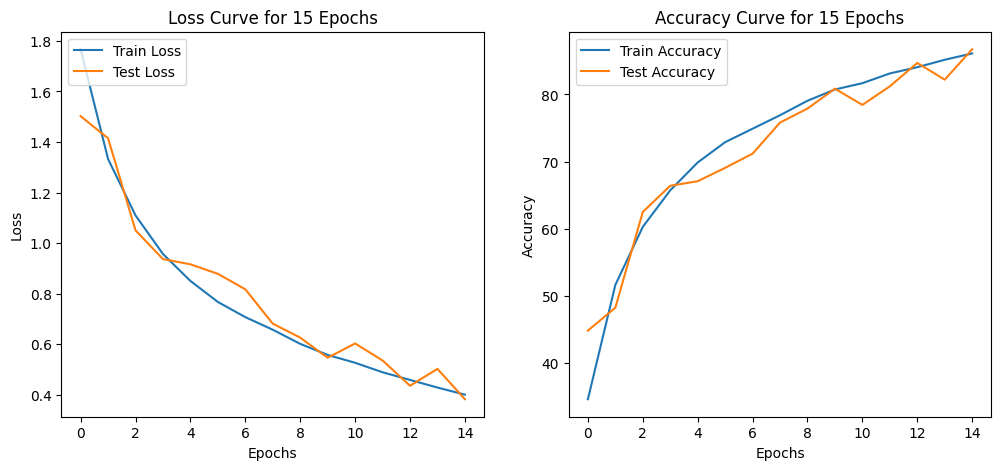

In [19]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc, num_epochs)

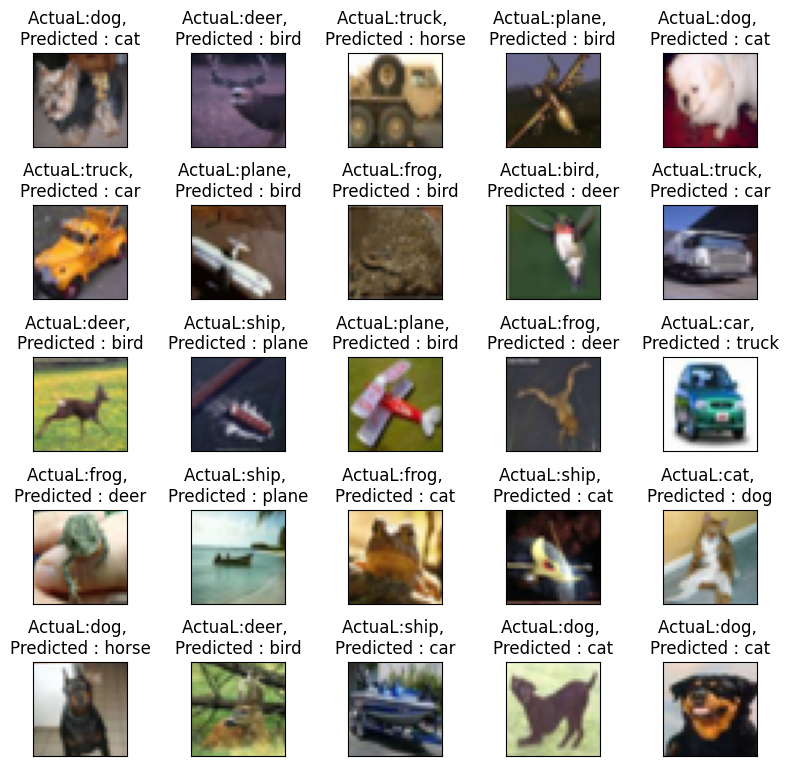

In [15]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes)
  break
